In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [180]:
# Import relevant tables
job_post = pd.read_csv('Data/job_postings.csv')
job_skills = pd.read_csv('Data/job_skills.csv')
skills_map = pd.read_csv('Data/skills.csv')
job_industries = pd.read_csv('Data/job_industries.csv')
industries_map = pd.read_csv('Data/industries.csv')

In [181]:
# Add skills and industries to job_post DF 
job_skills = job_skills.merge(skills_map)[['job_id','skill_name']]
job_industries = job_industries.merge(industries_map)[['job_id','industry_name']]
jobs = job_post.merge(job_skills).merge(job_industries)

In [182]:
# Drop rows where all of the salary fields are Null and rows where the work type isn't full time
salary_cols = ['max_salary','med_salary','min_salary']
jobs_cleaned = jobs.dropna(subset=salary_cols, how='all')
jobs_cleaned = jobs_cleaned[jobs_cleaned.formatted_work_type == 'Full-time']

In [183]:
# Transform all salaries to be Yearly based on the pay period (Monthly is 12x and Hourly is 2080x)
for column in salary_cols:
    jobs_cleaned.loc[jobs_cleaned['pay_period'] == 'MONTHLY', column] = jobs_cleaned.loc[jobs_cleaned['pay_period'] == 'MONTHLY', column] * 12
    jobs_cleaned.loc[jobs_cleaned['pay_period'] == 'HOURLY', column] = jobs_cleaned.loc[jobs_cleaned['pay_period'] == 'HOURLY', column] * 2080

In [184]:
# Impute missing medians based on median = min+max/2
impute_values = (jobs_cleaned['min_salary'] + jobs_cleaned['max_salary']) / 2

jobs_cleaned.loc[jobs_cleaned['med_salary'].isna(), 'med_salary'] = impute_values

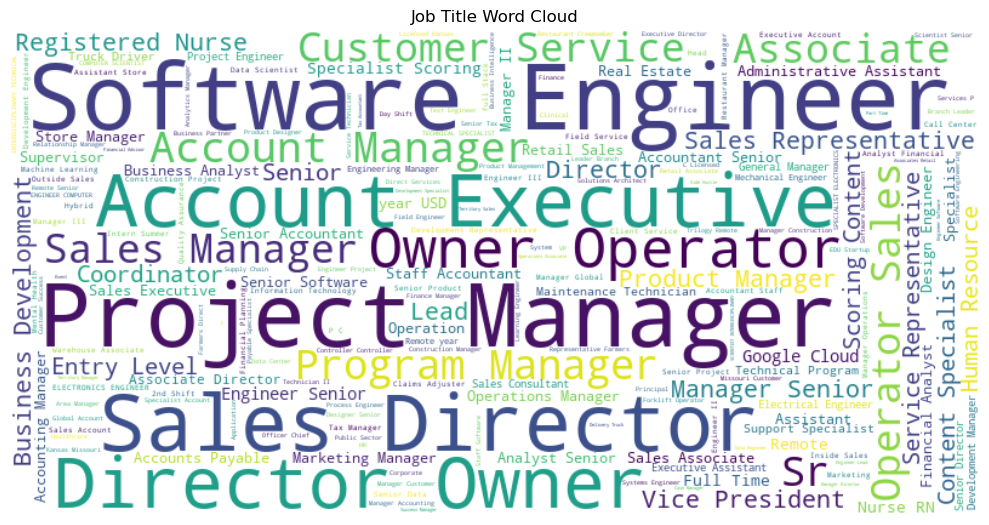

In [185]:
# Create a word cloud from job titles
job_titles_text = ' '.join(jobs_cleaned['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(job_titles_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Job Title Word Cloud')
plt.axis('off')
plt.tight_layout()
plt.show()

In [186]:
jobs_cleaned.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,skill_name,industry_name
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,63000.0,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,Other,Medical Equipment Manufacturing
4,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Management,Non-profit Organizations
5,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Manufacturing,Non-profit Organizations
6,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,"Technology, Information and Internet"
7,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,Manufacturing


In [187]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
jobs_cleaned['title_enc'] = label_encoder.fit_transform(jobs_cleaned['title'])
jobs_cleaned['location_enc'] = label_encoder.fit_transform(jobs_cleaned['location'])
jobs_cleaned['skill_name_enc'] = label_encoder.fit_transform(jobs_cleaned['skill_name'])
jobs_cleaned['formatted_experience_level_enc'] = label_encoder.fit_transform(jobs_cleaned['formatted_experience_level'])


X = jobs_cleaned[['title_enc', 'location_enc','skill_name_enc','formatted_experience_level_enc']]
y = jobs_cleaned['med_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# XGBoost

In [188]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_test)


In [189]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")


RMSE: 2951364.199197511


In [190]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [191]:
y_pred = grid_search.predict(X_test)

In [192]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 245365.4971184798


# Catboost Regressor

In [194]:
from feature_engine.encoding import RareLabelEncoder

# select label
df = jobs_cleaned[['title','location','skill_name','med_salary','formatted_experience_level','industry_name']]
main_label = 'med_salary'
# Exclude 1% of smallest and 1% of highest values
P = np.percentile(df[main_label], [1, 99])
df = df[(df[main_label] > P[0]) & (df[main_label] < P[1])]

# log10-transform columns and group by larger bins
def log10_transform(x):
    try: 
        return str(round(1/5*round(5*np.log10(1+x)),1))
    except:
        return 'None'
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['title','location','skill_name','formatted_experience_level','industry_name']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=10.0/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
print(df.shape)
df.sample(5).T

(27776, 6)


,15137,3800,65015,5053,28198
title,Other,Other,Other,Other,Other
location,"New York, NY","San Jose, CA","Cincinnati, OH",Other,Other
skill_name,Product Management,Engineering,Finance,Marketing,Sales
med_salary,217500.0,156050.0,54050.0,119500.0,135000.0
formatted_experience_level,None,None,None,None,Director
industry_name,Financial Services,Other,Business Consulting and Services,Manufacturing,"Technology, Information and Internet"


In [201]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df[['title','location','skill_name','formatted_experience_level','industry_name']]
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=df[['title']])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13888, 5), (13888, 5), (13888,), (13888,))

In [202]:
from catboost import Pool, CatBoostRegressor

# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=2000, 
                          depth=5,
                          verbose=0,
                          learning_rate=0.01, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,3)} USD/year, and for test {round(rmse_test,3)} USD/year")

RMSE score for train 36052.732 USD/year, and for test 37479.148 USD/year


In [230]:
# Example user input
for location in jobs_cleaned['location'].unique():
    user_input = {
        'title': ['Software Engineer'],
        'location': [f'{location}'],
        'skill_name': ['Information Technology'],
        'formatted_experience_level': ['Mid-Senior level'],
        'industry_name': ['Technology, Information and Internet']
    }

    user_input_df = pd.DataFrame(user_input)

    # Predict the salary for the user input
    predicted_salary = model.predict(user_input_df)
    print(f"----{location}-----")
    print(f"Estimated salary: {predicted_salary[0]:.2f} USD/year")


----Little River, SC-----
Estimated salary: 141952.63 USD/year
----Aliso Viejo, CA-----
Estimated salary: 141952.63 USD/year
----United States-----
Estimated salary: 142063.01 USD/year
----Coeur d'Alene, ID-----
Estimated salary: 141952.63 USD/year
----Altadena, CA-----
Estimated salary: 141952.63 USD/year
----Waukesha, WI-----
Estimated salary: 141952.63 USD/year
----Orlando, FL-----
Estimated salary: 135427.24 USD/year
----Oakland, CA-----
Estimated salary: 142914.59 USD/year
----Broomfield, CO-----
Estimated salary: 141952.63 USD/year
----Swedesboro, NJ-----
Estimated salary: 141952.63 USD/year
----Richmond, VA-----
Estimated salary: 141952.63 USD/year
----Rapid City, SD-----
Estimated salary: 141952.63 USD/year
----Yuma, AZ-----
Estimated salary: 141952.63 USD/year
----Sheboygan, WI-----
Estimated salary: 141952.63 USD/year
----Portland, OR-----
Estimated salary: 131479.88 USD/year
----Urbana-Champaign Area-----
Estimated salary: 141952.63 USD/year
----Marietta, GA-----
Estimated s

----Madison, WI-----
Estimated salary: 141952.63 USD/year
----Enterprise, AL-----
Estimated salary: 141952.63 USD/year
----Lexington, NC-----
Estimated salary: 141952.63 USD/year
----Riviera Beach, FL-----
Estimated salary: 141952.63 USD/year
----Santa Monica, CA-----
Estimated salary: 141952.63 USD/year
----Ocean Township, NJ-----
Estimated salary: 141952.63 USD/year
----Topsham, ME-----
Estimated salary: 141952.63 USD/year
----Rockingham, NC-----
Estimated salary: 141952.63 USD/year
----Homewood, IL-----
Estimated salary: 141952.63 USD/year
----Manchester, NH-----
Estimated salary: 141952.63 USD/year
----Cortland, NY-----
Estimated salary: 141952.63 USD/year
----West Palm Beach, FL-----
Estimated salary: 141952.63 USD/year
----Fort Myer Heights, VA-----
Estimated salary: 141952.63 USD/year
----Austin, Texas Metropolitan Area-----
Estimated salary: 145980.29 USD/year
----Elgin, SC-----
Estimated salary: 141952.63 USD/year
----Fontana, CA-----
Estimated salary: 141952.63 USD/year
----R

----Vernon, CA-----
Estimated salary: 141952.63 USD/year
----Irvine, California, United States-----
Estimated salary: 141952.63 USD/year
----Boston, Massachusetts, United States-----
Estimated salary: 141952.63 USD/year
----Thornton, CO-----
Estimated salary: 141952.63 USD/year
----New Berlin, WI-----
Estimated salary: 141952.63 USD/year
----Elmsford, NY-----
Estimated salary: 141952.63 USD/year
----Uniondale, NY-----
Estimated salary: 141952.63 USD/year
----High Point, NC-----
Estimated salary: 141952.63 USD/year
----Downers Grove, IL-----
Estimated salary: 141952.63 USD/year
----Charleston, South Carolina, United States-----
Estimated salary: 141952.63 USD/year
----Waterbury, CT-----
Estimated salary: 141952.63 USD/year
----West Nyack, NY-----
Estimated salary: 141952.63 USD/year
----Boulder County, CO-----
Estimated salary: 141952.63 USD/year
----Jamestown, NM-----
Estimated salary: 141952.63 USD/year
----Cleveland, TN-----
Estimated salary: 141952.63 USD/year
----Quakertown, PA----

----Mauldin, SC-----
Estimated salary: 141952.63 USD/year
----Lowell, AR-----
Estimated salary: 141952.63 USD/year
----Johnstown, NY-----
Estimated salary: 141952.63 USD/year
----Aledo, TX-----
Estimated salary: 141952.63 USD/year
----Lebanon, NH-----
Estimated salary: 141952.63 USD/year
----Pine Bluff, AR-----
Estimated salary: 141952.63 USD/year
----Garland, TX-----
Estimated salary: 141952.63 USD/year
----Moonachie, NJ-----
Estimated salary: 141952.63 USD/year
----Carrollton, TX-----
Estimated salary: 141952.63 USD/year
----Mahwah, NJ-----
Estimated salary: 141952.63 USD/year
----Reading, PA-----
Estimated salary: 141952.63 USD/year
----Middletown, IA-----
Estimated salary: 141952.63 USD/year
----Fairburn, GA-----
Estimated salary: 141952.63 USD/year
----Parsons, KS-----
Estimated salary: 141952.63 USD/year
----Watertown, SD-----
Estimated salary: 141952.63 USD/year
----Cobb County, GA-----
Estimated salary: 141952.63 USD/year
----Fort Walton Beach, FL-----
Estimated salary: 141952.